In [1]:
import numpy as np

import sympy as sym

import itertools

In [2]:
from importlib.machinery import SourceFileLoader

main = SourceFileLoader(
    "main", "main.py"
).load_module()

from main import *

**Payoffs Formulation**

In [6]:
c = np.random.randint(0, 1)
b = np.random.randint(1, 3)

for _ in range(100):
    
    p1, p2, q1, q2 = np.random.random(4)
    
    one_bit_M = transition_matrix_one_bit(p=[p1, p2], q=[q1, q2])
    
    two_bit_M = transition_matrix_two_bit(p=[p1, p2, p1, p2], q=[q1, q2, q1, q2])
    
    ss_one_bit = invariant_distribution(one_bit_M)
    ss_two_bit = invariant_distribution(two_bit_M)    

    
    assert np.isclose(ss_one_bit @ np.array([b - c, -c, b, 0]),
                      ss_two_bit @ payoffs_vector(c, b))

**Cooperation**

In [4]:
c = np.random.randint(0, 1)
b = np.random.randint(1, 3)

for _ in range(100):
    
    p1, p2, q1, q2 = np.random.random(4)
    
    one_bit_M = transition_matrix_one_bit(p=[p1, p2], q=[q1, q2])
    
    two_bit_M = transition_matrix_two_bit(p=[p1, p2, p1, p2], q=[q1, q2, q1, q2])
    
    ss_one_bit = invariant_distribution(one_bit_M)
    ss_two_bit = invariant_distribution(two_bit_M) 
    
    assert np.isclose(ss_one_bit[0] + ss_one_bit[1],
                     (ss_two_bit[0] + ss_two_bit[4] + ss_two_bit[8] + ss_two_bit[12] +
                      ss_two_bit[1] + ss_two_bit[5] + ss_two_bit[9] + ss_two_bit[13]))

In [36]:
def cooperation(ss):
    return (ss[0] + ss[4] + ss[8] + ss[12] +
            ss[1] + ss[5] + ss[9] + ss[13])

**Checks for matlab code**

In [37]:
p1, p2 = np.random.random(4), np.random.random(4)

In [38]:
p1, p2

(array([0.48740259, 0.33323227, 0.82350304, 0.71276159]),
 array([0.67229974, 0.47205614, 0.04880383, 0.43523115]))

In [39]:
M  = transition_matrix_two_bit(p1, p2)

ss = invariant_distribution(M) 

In [40]:
ss

array([0.06870497, 0.104097  , 0.03468364, 0.05306706, 0.07672123,
       0.10411194, 0.06989294, 0.09344265, 0.05555534, 0.06579002,
       0.02260441, 0.02678415, 0.05957113, 0.07016981, 0.04355292,
       0.0512508 ])

In [41]:
c = 0.1

In [42]:
ss @ payoffs_vector(c, b)

0.37081443961437865

In [43]:
cooperation(ss)

0.60472142605001

In [30]:
ss_two_bit[0] + ss_two_bit[4] + ss_two_bit[8] + ss_two_bit[12] +
            ss_two_bit[1] + ss_two_bit[5] + ss_two_bit[9] + ss_two_bit[13]

0.06760884730315153

**Evolutionary "simulations"**

In [18]:
N = 100
c = 1
b = 3
beta = 1
max_steps = 10

In [19]:
residents = simulate_process(N, c, b, beta, max_steps)

100%|██████████| 9/9 [00:00<00:00, 657.27it/s]


In [20]:
np.savetxt(f"test.csv", np.array(residents), delimiter=",")

In [21]:
import pandas as pd

In [22]:
pd.read_csv("test.csv")

,1.000000000000000000e+00,1.000000000000000000e+00.1,1.000000000000000000e+00.2,1.000000000000000000e+00.3,0.000000000000000000e+00,1.000000000000000000e+00.4
0,0.774626,0.918875,0.097085,0.273629,1.0,0.101029
1,0.120603,0.237812,0.829190,0.147116,4.0,0.637168


In [17]:
steady_states = []

for p, q in itertools.product([mutant, current_resident], repeat=2):
    
    M = transition_matrix_two_bit(p, q)
    steady_states.append(invariant_distribution(M))

In [18]:
payoff_MM, payoff_MR, payoff_RM, payoff_RR = [
    state @ payoffs_vector(c, b) for state in steady_states
]
lminus, lplus = [], []
for k in range(1, N):
    expected_payoff_mutant = ((k - 1) / (N - 1) * payoff_MM) + (
        (N - k) / (N - 1)
    ) * payoff_MR
    expected_payoff_resident = (k / (N - 1) * payoff_RM) + (
        (N - k - 1) / (N - 1)
    ) * payoff_RR

    lplus.append(
        1
        / (
            1
            + np.exp(
                float(
                    -beta
                    * (expected_payoff_mutant - expected_payoff_resident)
                )
            )
        )
    )
    lminus.append(
        1
        / (
            1
            + np.exp(
                float(
                    -beta
                    * (expected_payoff_resident - expected_payoff_mutant)
                )
            )
        )
    )
gammas = np.array(lminus) / np.array(lplus)


if random_.random() < 1 / (1 + np.sum(np.cumprod(gammas))):
    cooperation_rate = steady_states[0][0] + steady_states[0][1]
    residents.append(list(np.random.random(4)) + [t] + [cooperation_rate])

In [ ]:
transition_matrix_two_bit(p=[p1, p2, p1, p2], q=[q1, q2, q1, q2])

In [20]:
residents

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [7]:
mutant = np.random.random(4)

In [22]:
list(mutant) + [100]

[0.8004920307378571,
 0.8549783346024027,
 0.29913219621761145,
 0.9383117294180656,
 100]

In [18]:
np.r_[mutant, 100]

array([  0.80049203,   0.85497833,   0.2991322 ,   0.93831173,
       100.        ])

In [13]:
residents[0]

array([0, 0, 0, 0, 0])

In [193]:
N = 100
beta = 10
mu = 1

In [194]:
one_bit_strategies = strategies_set(2)

one_bit_strategies = np.tile(one_bit_strategies, 2)

In [195]:
stationaries = []
b = 3

for c in np.linspace(0, 0.99999, 100):
    
    abd_m, _ = abundance_matrix(one_bit_strategies, c, b, N, beta, mu)
    ss = invariant_distribution(abd_m)
    
    stationaries.append(ss)

/Users/glynatsi/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [196]:
m, pf = abundance_matrix(one_bit_strategies, c, b, N, beta, mu)

In [197]:
pf.round(3)

array([[ 0.,  3.,  0.,  3.],
       [-1.,  1.,  1.,  3.],
       [ 0.,  1.,  1.,  2.],
       [-1., -1.,  2.,  2.]])

In [199]:
one_bit_strategies

array([[0, 0, 0, 0],
       [0, 1, 0, 1],
       [1, 0, 1, 0],
       [1, 1, 1, 1]])

In [198]:
ss = invariant_distribution(m)

ss

array([0.71451906, 0.07189655, 0.14239038, 0.071194  ])

In [185]:
coop = []
for stationary in stationaries:
    p = one_bit_strategies[np.argmax(stationary)]
    
    M = transition_matrix_two_bit(p, p)
    
    ss = invariant_distribution(M)
    
    coop.append(cooperation(ss))
    

In [186]:
import matplotlib.pyplot as plt

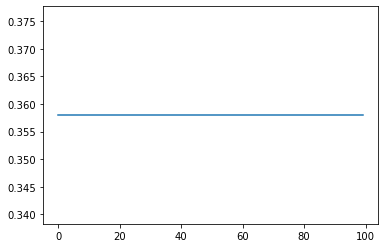

In [187]:
plt.plot(coop);

In [206]:
np.random.random((1, 5)) * 5

array([3.58888946, 0.57421447, 0.25763167, 3.20558745, 3.57515323])

In [204]:
np.array([1, 2] * 5)

array([1, 2, 1, 2, 1, 2, 1, 2, 1, 2])

In [207]:
resident = np.random.random(5)

In [209]:
resident

array([0.98317722, 0.84933645, 0.48157125, 0.60934658, 0.70641782])

In [213]:
np.random.seed(0)
np.repeat(np.random.random((1,5)), 3, axis=0)

array([[0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ],
       [0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ],
       [0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ]])

In [214]:
np.random.random((1,5))

array([[0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152]])

In [215]:
ss = np.repeat(np.random.random((1,5)), 3, axis=0)

In [216]:
ss = np.repeat(np.random.random((1,5)), 3, axis=0)

In [217]:
ss

array([[0.0871293 , 0.0202184 , 0.83261985, 0.77815675, 0.87001215],
       [0.0871293 , 0.0202184 , 0.83261985, 0.77815675, 0.87001215],
       [0.0871293 , 0.0202184 , 0.83261985, 0.77815675, 0.87001215]])

In [ ]:
np.savetxt('example.txt', np.c_[time, operation1, operation2],
            header='Filexy\ntime  operation1 operation2', fmt='%d',
               delimiter='\t')

In [218]:
[*ss[0], *ss[2], cooperation]

[0.08712929970154071,
 0.02021839744032572,
 0.832619845547938,
 0.7781567509498505,
 0.8700121482468192,
 0.08712929970154071,
 0.02021839744032572,
 0.832619845547938,
 0.7781567509498505,
 0.8700121482468192]

In [24]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [25]:
for c in np.linspace(0, 1, 11):
    print(f"sbatch sh/c_{c}.sh")

sbatch sh/c_0.0.sh
sbatch sh/c_0.1.sh
sbatch sh/c_0.2.sh
sbatch sh/c_0.30000000000000004.sh
sbatch sh/c_0.4.sh
sbatch sh/c_0.5.sh
sbatch sh/c_0.6000000000000001.sh
sbatch sh/c_0.7000000000000001.sh
sbatch sh/c_0.8.sh
sbatch sh/c_0.9.sh
sbatch sh/c_1.0.sh
